In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/12-class-ssvep-eeg-data/s2.mat
/kaggle/input/12-class-ssvep-eeg-data/s5.mat
/kaggle/input/12-class-ssvep-eeg-data/s6.mat
/kaggle/input/12-class-ssvep-eeg-data/s10.mat
/kaggle/input/12-class-ssvep-eeg-data/s8.mat
/kaggle/input/12-class-ssvep-eeg-data/s7.mat
/kaggle/input/12-class-ssvep-eeg-data/s1.mat
/kaggle/input/12-class-ssvep-eeg-data/s3.mat
/kaggle/input/12-class-ssvep-eeg-data/s4.mat
/kaggle/input/12-class-ssvep-eeg-data/s9.mat


# Perform Frequency Response calculated using FFT 

## 1. Load the Datasets

### Libs

In [8]:
import ssvep_ultils as su
import os
import numpy as np
from scipy.io import loadmat
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### Plot Spectrum 

In [9]:
data_files = [
    '/kaggle/input/12-class-ssvep-eeg-data/s1.mat',
    '/kaggle/input/12-class-ssvep-eeg-data/s2.mat',
    '/kaggle/input/12-class-ssvep-eeg-data/s3.mat',
    '/kaggle/input/12-class-ssvep-eeg-data/s4.mat',
    
    '/kaggle/input/12-class-ssvep-eeg-data/s5.mat',
    '/kaggle/input/12-class-ssvep-eeg-data/s6.mat',
    '/kaggle/input/12-class-ssvep-eeg-data/s7.mat',
    '/kaggle/input/12-class-ssvep-eeg-data/s8.mat',
    '/kaggle/input/12-class-ssvep-eeg-data/s9.mat',
    '/kaggle/input/12-class-ssvep-eeg-data/s10.mat',
]

### Define plot and set FFT params 

In [10]:
FFT_PARAMS = {
    'resolution': 0.2930,
    'start_frequency': 0.0,
    'end_frequency': 35.0,
    'sampling_rate': 256
}

def plot_spectrum(ax, magnitude_spectrum, resolution, num_classes, subject, channel, flicker_freq):
    for target in range(num_classes):
        fft_axis = np.arange(magnitude_spectrum.shape[0]) * resolution
        valid_idx = (fft_axis >= FFT_PARAMS['start_frequency']) & (fft_axis <= FFT_PARAMS['end_frequency'])
        fft_axis = fft_axis[valid_idx]
        spectrum = np.mean(np.squeeze(magnitude_spectrum[:, channel, target, :, :]), axis=1)[valid_idx]
        
        ax[target].plot(fft_axis, spectrum)
        ax[target].set_xlabel('Frequency (Hz)') 
        ax[target].set_ylabel('Amplitude (uV)')
        ax[target].set_title(f'Subject {subject} stimulus frequency {flicker_freq[target]} Hz')
    plt.tight_layout()
    plt.show()

### Set parameters for FFT transforms

In [11]:
all_segment_data = dict()
magnitude_spectrum = dict()
all_acc = list()
window_len = 4
shift_len = 4
sample_rate = 256
duration = int(window_len * sample_rate)
FFT_PARAMS = {
    'resolution': sample_rate / (window_len * sample_rate),
    'start_frequency': 0.0,
    'end_frequency': 35.0,
    'sampling_rate': sample_rate
}
flicker_freq = np.array([9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 
                         10.25, 12.25, 14.25, 10.75, 12.75, 14.75])


### Load the data

In [12]:
for file_path in data_files:
    subject_id = os.path.basename(file_path).split('.')[0]  # Lấy tên file không bao gồm phần mở rộng
    print(f"Loading data for {subject_id} from {file_path}...")
    data = loadmat(file_path)  # Load dữ liệu từ file .mat
    eeg = np.array(data['eeg'], dtype='float32')

    # Lấy thông tin từ dữ liệu EEG
    num_classes = eeg.shape[0]
    n_ch = eeg.shape[1]
    total_trial_len = eeg.shape[2]
    num_trials = eeg.shape[3]

    # Xử lý dữ liệu
    filtered_data = su.get_filtered_eeg(eeg, 6, 80, 4, sample_rate)
    segmented_data = su.get_segmented_epochs(filtered_data, window_len, shift_len, sample_rate)
    magnitude_spectrum[subject_id] = su.magnitude_spectrum_features(segmented_data, FFT_PARAMS)
    all_segment_data[subject_id] = segmented_data

print("Data loading and preprocessing completed.")

Loading data for s1 from /kaggle/input/12-class-ssvep-eeg-data/s1.mat...
Loading data for s2 from /kaggle/input/12-class-ssvep-eeg-data/s2.mat...
Loading data for s3 from /kaggle/input/12-class-ssvep-eeg-data/s3.mat...
Loading data for s4 from /kaggle/input/12-class-ssvep-eeg-data/s4.mat...
Loading data for s5 from /kaggle/input/12-class-ssvep-eeg-data/s5.mat...
Loading data for s6 from /kaggle/input/12-class-ssvep-eeg-data/s6.mat...
Loading data for s7 from /kaggle/input/12-class-ssvep-eeg-data/s7.mat...
Loading data for s8 from /kaggle/input/12-class-ssvep-eeg-data/s8.mat...
Loading data for s9 from /kaggle/input/12-class-ssvep-eeg-data/s9.mat...
Loading data for s10 from /kaggle/input/12-class-ssvep-eeg-data/s10.mat...
Data loading and preprocessing completed.


## 2. Frequency response for the signal duration of 4s of EEG data using FFT

### Subject 1

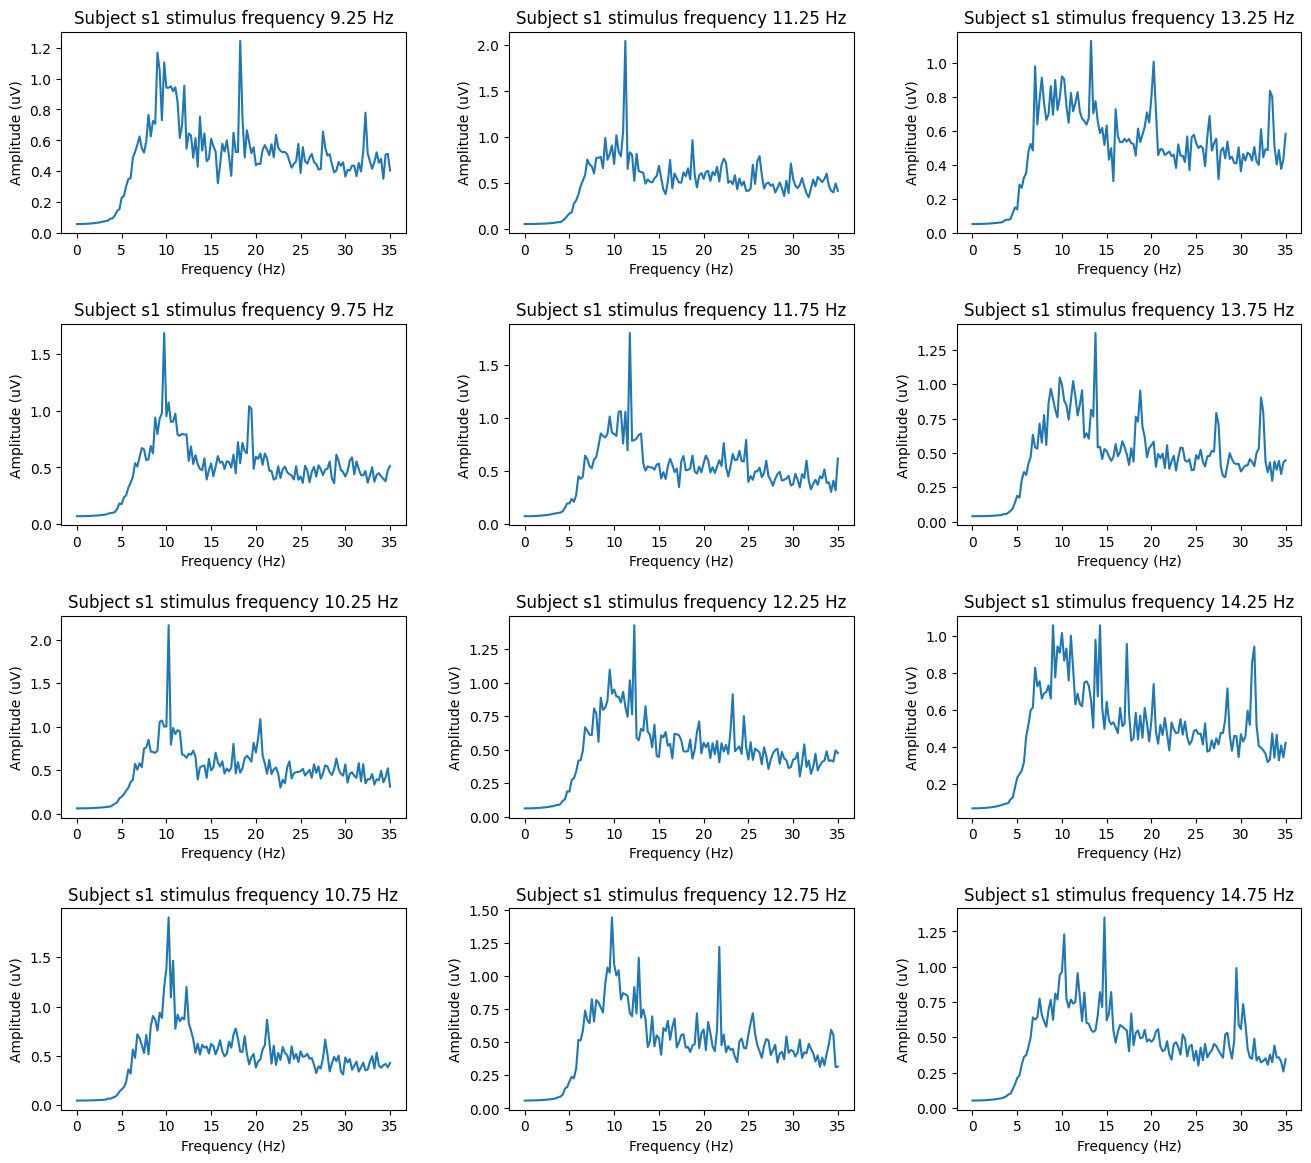

In [15]:
subject = 's1' 
channel = 7  

fig, axes = plt.subplots(4, 3, figsize=(16, 14), gridspec_kw=dict(hspace=0.45, wspace=0.3))
axes = axes.reshape(-1) 

plot_spectrum(axes, magnitude_spectrum[subject], FFT_PARAMS['resolution'], num_classes, 
               subject, channel, flicker_freq)


### Subject 2

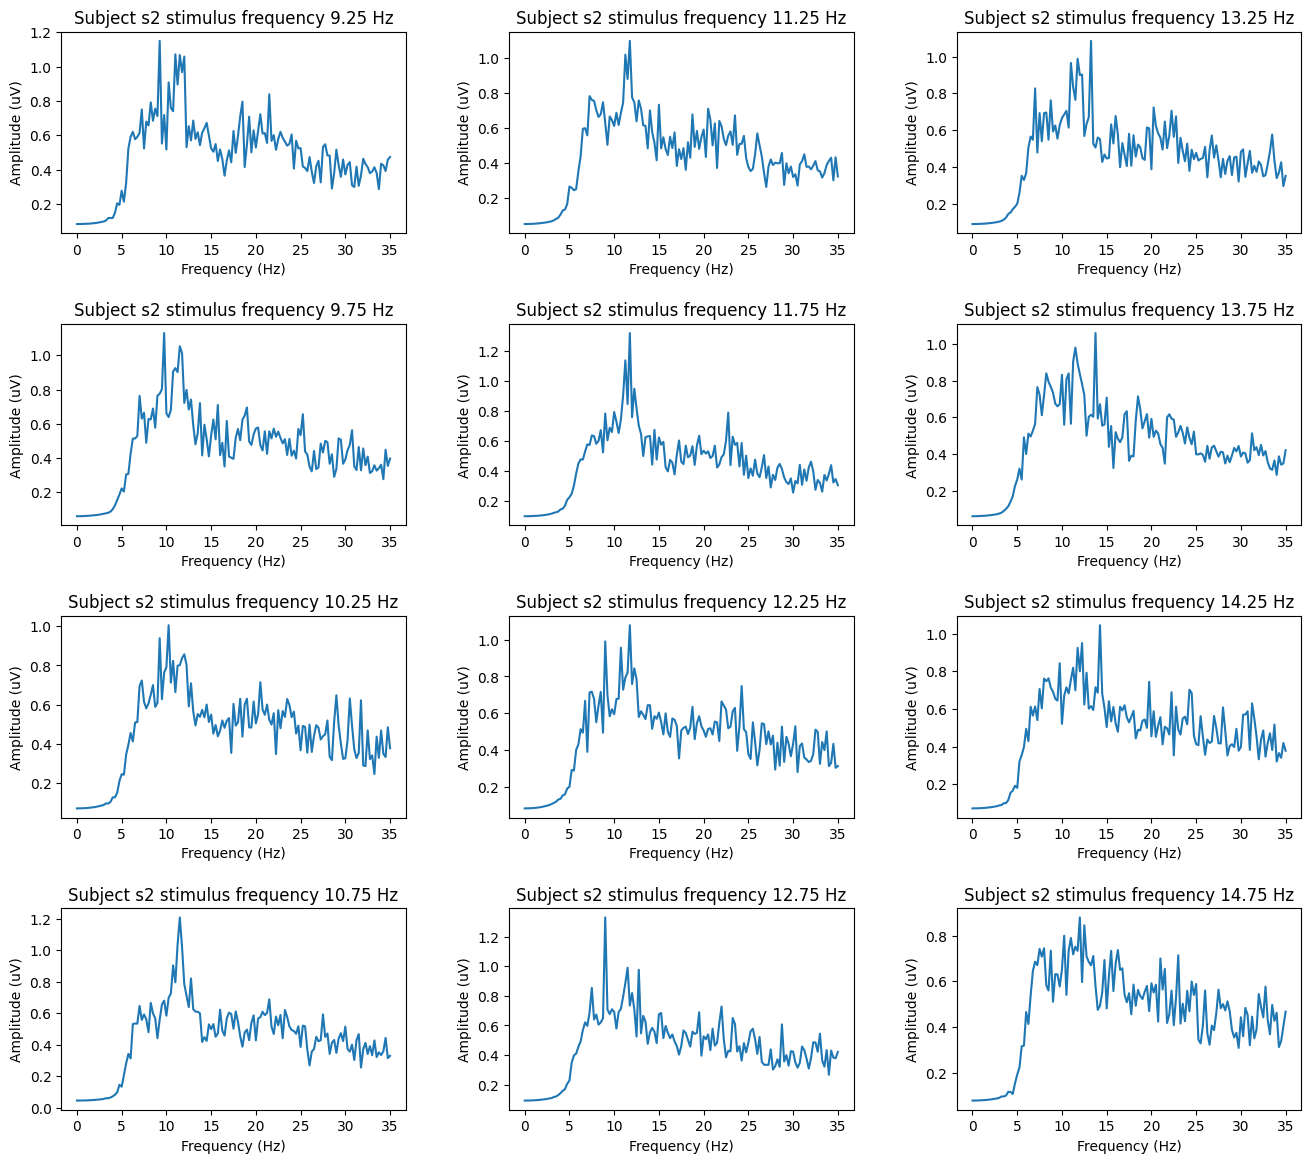

In [16]:
subject = 's2' 
channel = 7  

fig, axes = plt.subplots(4, 3, figsize=(16, 14), gridspec_kw=dict(hspace=0.45, wspace=0.3))
axes = axes.reshape(-1) 

plot_spectrum(axes, magnitude_spectrum[subject], FFT_PARAMS['resolution'], num_classes, 
               subject, channel, flicker_freq)


### Subject 3

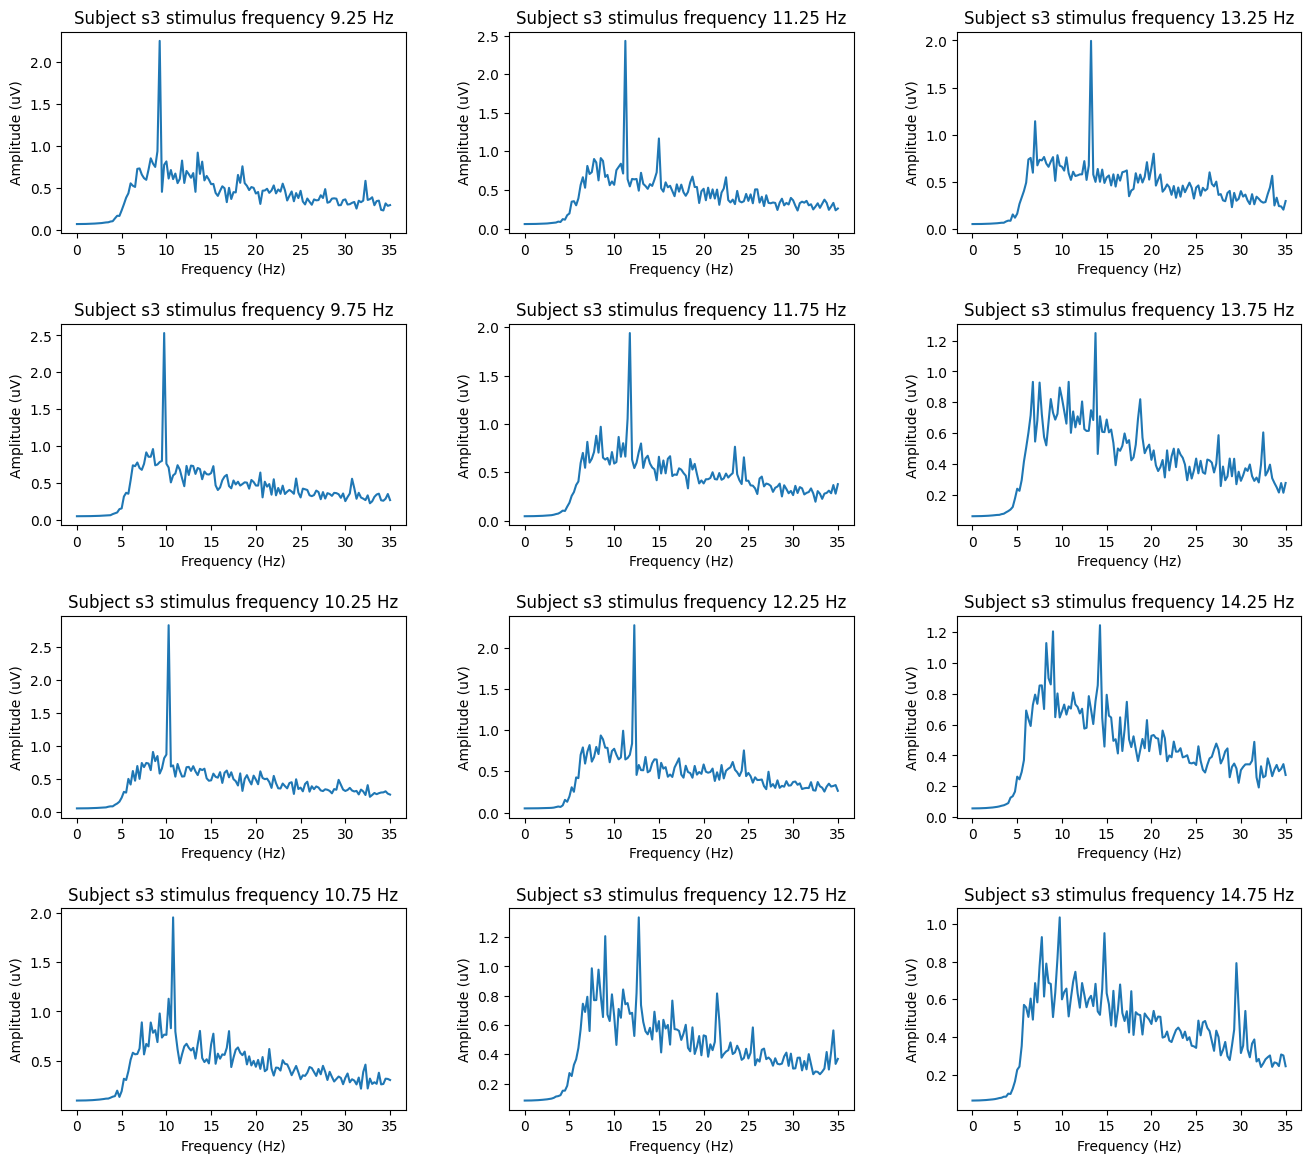

In [17]:
subject = 's3' 
channel = 7  

fig, axes = plt.subplots(4, 3, figsize=(16, 14), gridspec_kw=dict(hspace=0.45, wspace=0.3))
axes = axes.reshape(-1) 

plot_spectrum(axes, magnitude_spectrum[subject], FFT_PARAMS['resolution'], num_classes, 
               subject, channel, flicker_freq)


### Subject 4

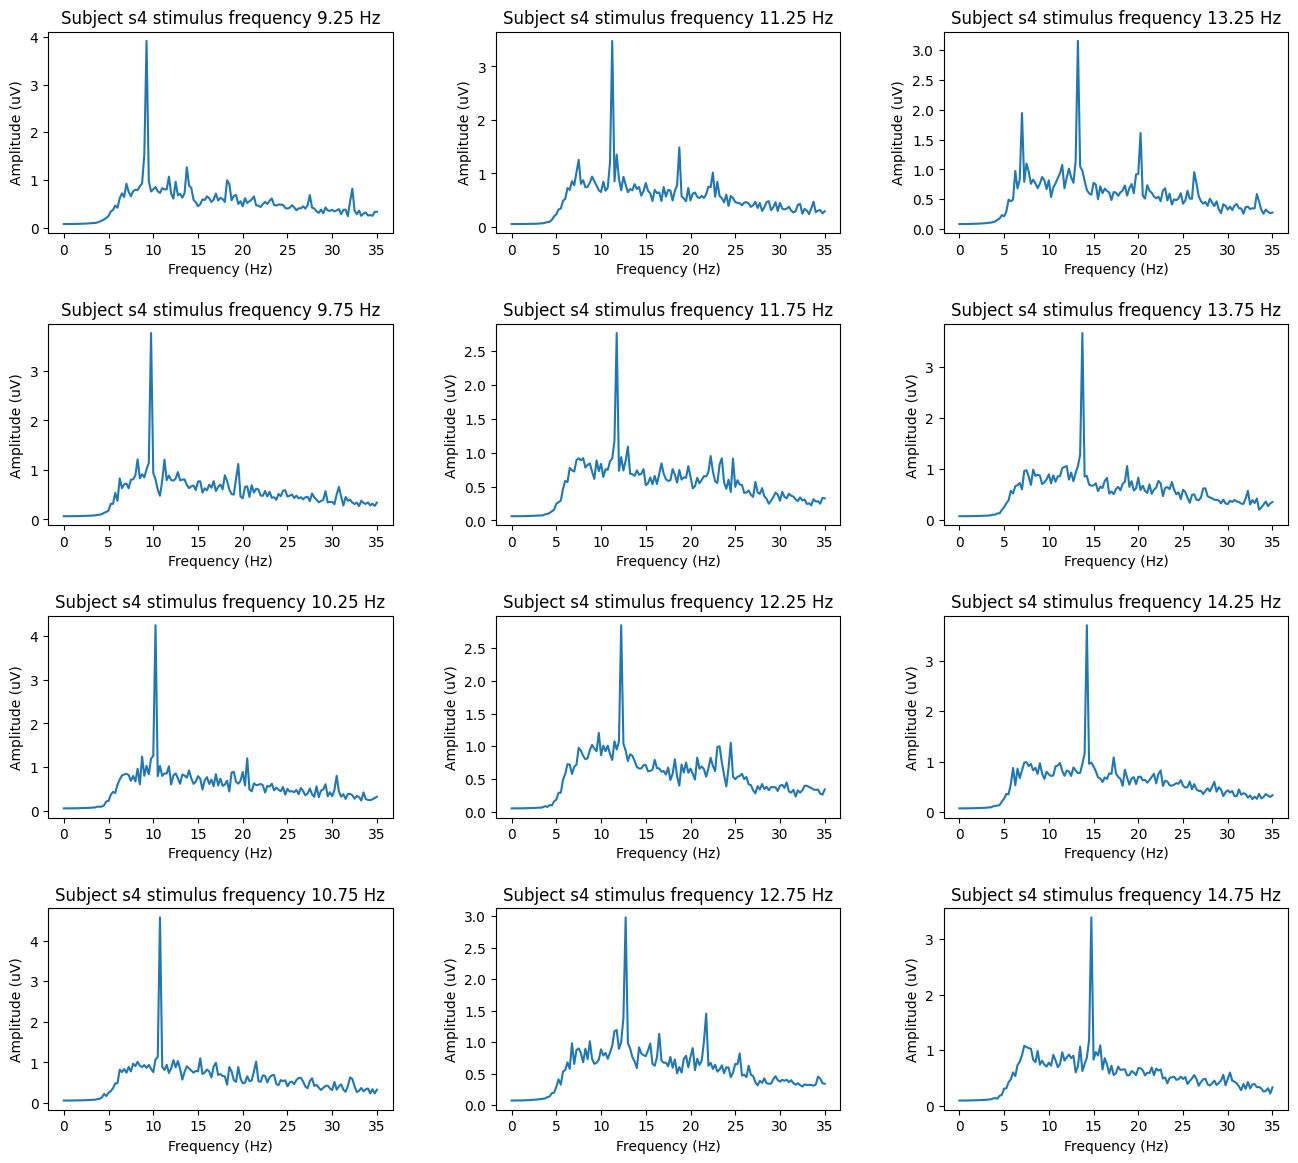

In [18]:
subject = 's4' 
channel = 7  

fig, axes = plt.subplots(4, 3, figsize=(16, 14), gridspec_kw=dict(hspace=0.45, wspace=0.3))
axes = axes.reshape(-1) 

plot_spectrum(axes, magnitude_spectrum[subject], FFT_PARAMS['resolution'], num_classes, 
               subject, channel, flicker_freq)


### Subject 5

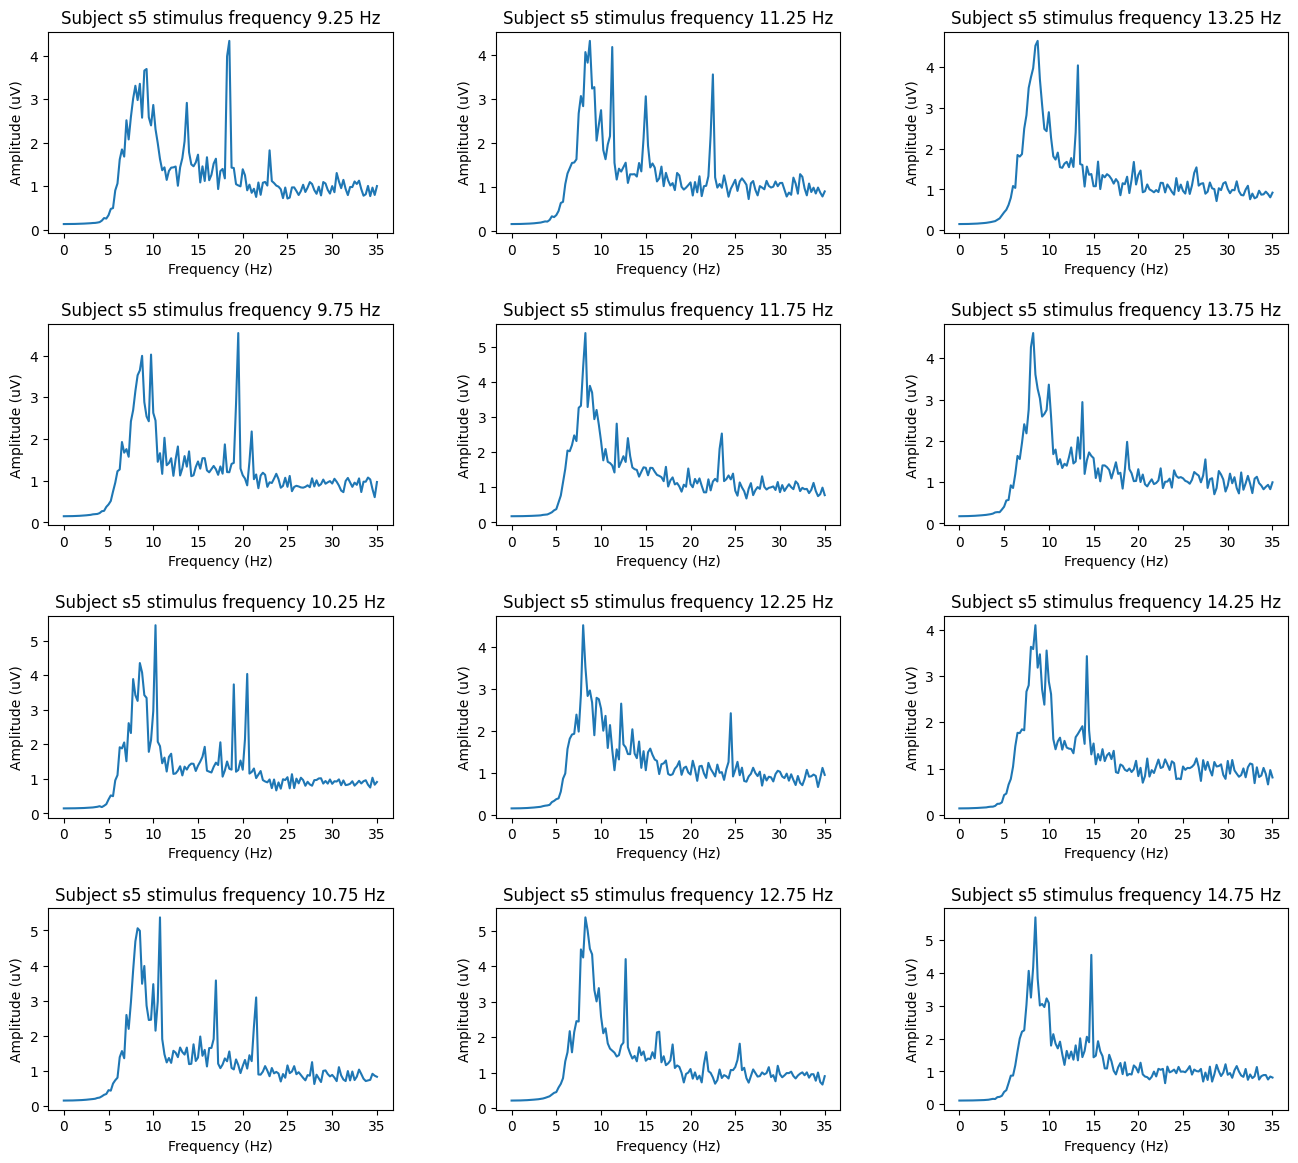

In [20]:
subject = 's5' 
channel = 7  

fig, axes = plt.subplots(4, 3, figsize=(16, 14), gridspec_kw=dict(hspace=0.45, wspace=0.3))
axes = axes.reshape(-1) 

plot_spectrum(axes, magnitude_spectrum[subject], FFT_PARAMS['resolution'], num_classes, 
               subject, channel, flicker_freq)

### Subject 6

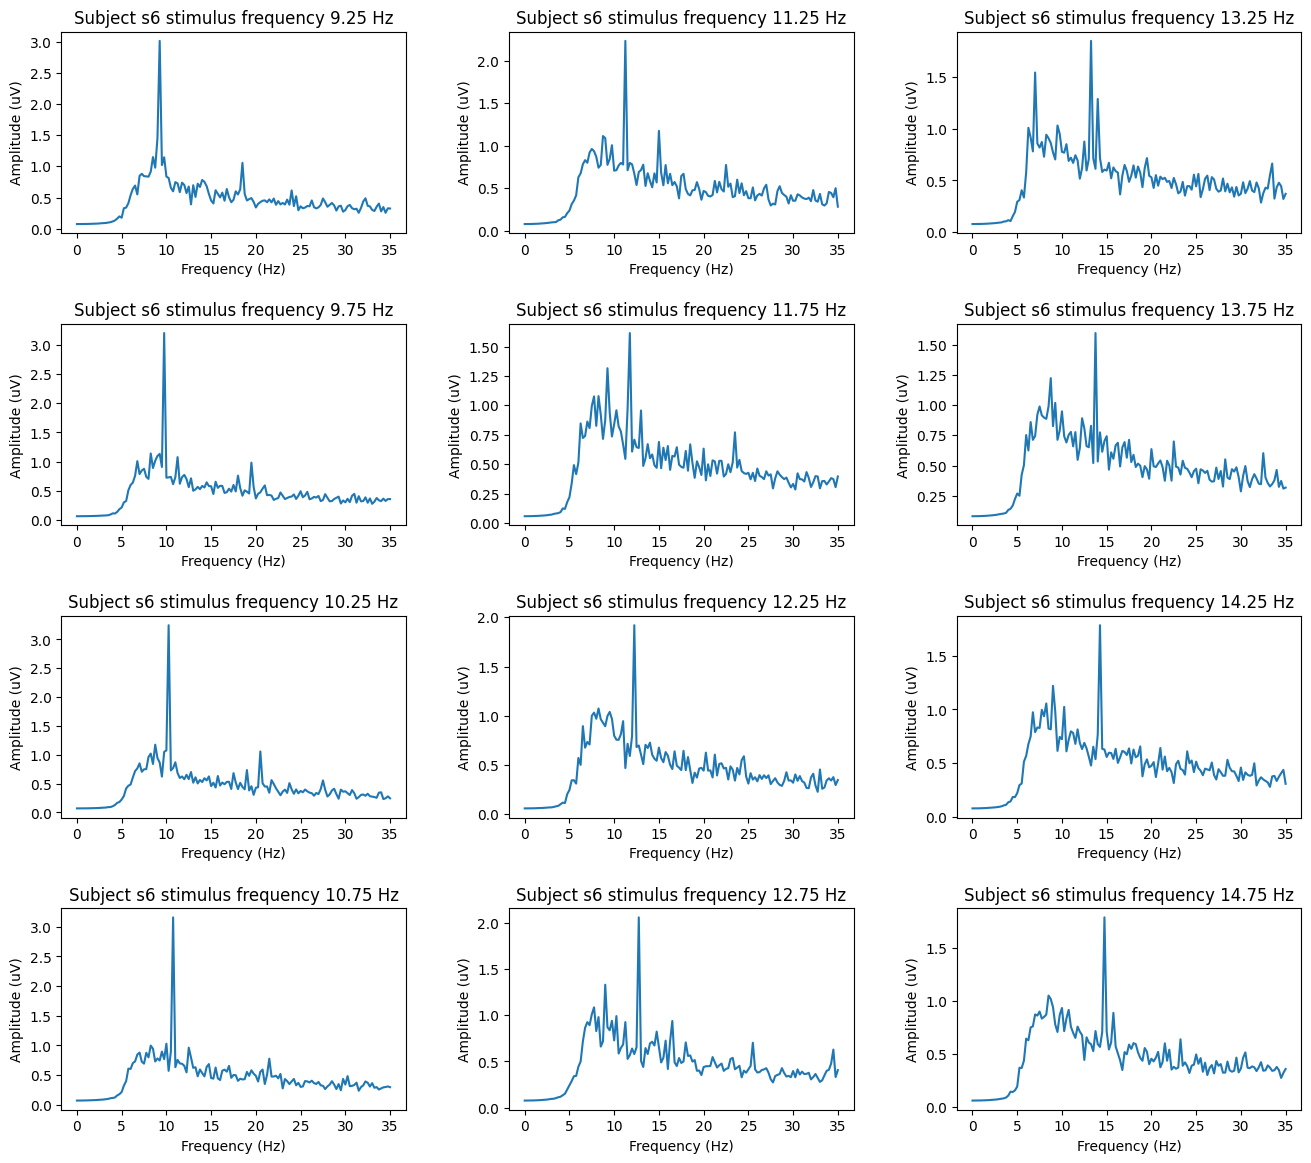

In [21]:
subject = 's6' 
channel = 7  

fig, axes = plt.subplots(4, 3, figsize=(16, 14), gridspec_kw=dict(hspace=0.45, wspace=0.3))
axes = axes.reshape(-1) 

plot_spectrum(axes, magnitude_spectrum[subject], FFT_PARAMS['resolution'], num_classes, 
               subject, channel, flicker_freq)


### Subject 7

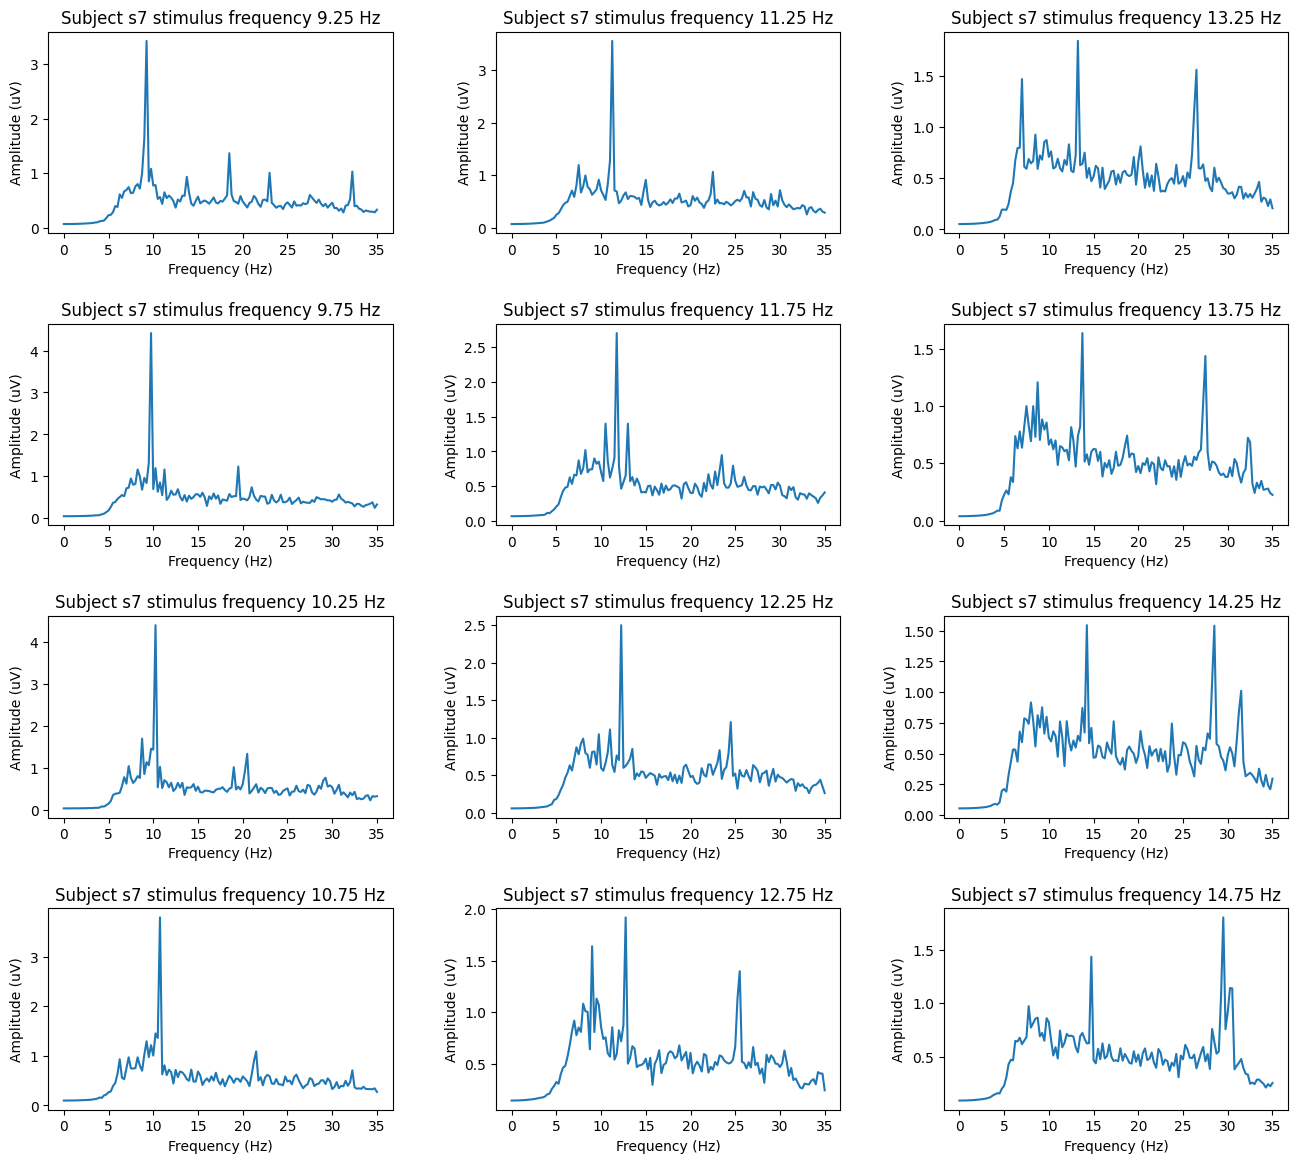

In [22]:
subject = 's7' 
channel = 7  

fig, axes = plt.subplots(4, 3, figsize=(16, 14), gridspec_kw=dict(hspace=0.45, wspace=0.3))
axes = axes.reshape(-1) 

plot_spectrum(axes, magnitude_spectrum[subject], FFT_PARAMS['resolution'], num_classes, 
               subject, channel, flicker_freq)


### Subject 8

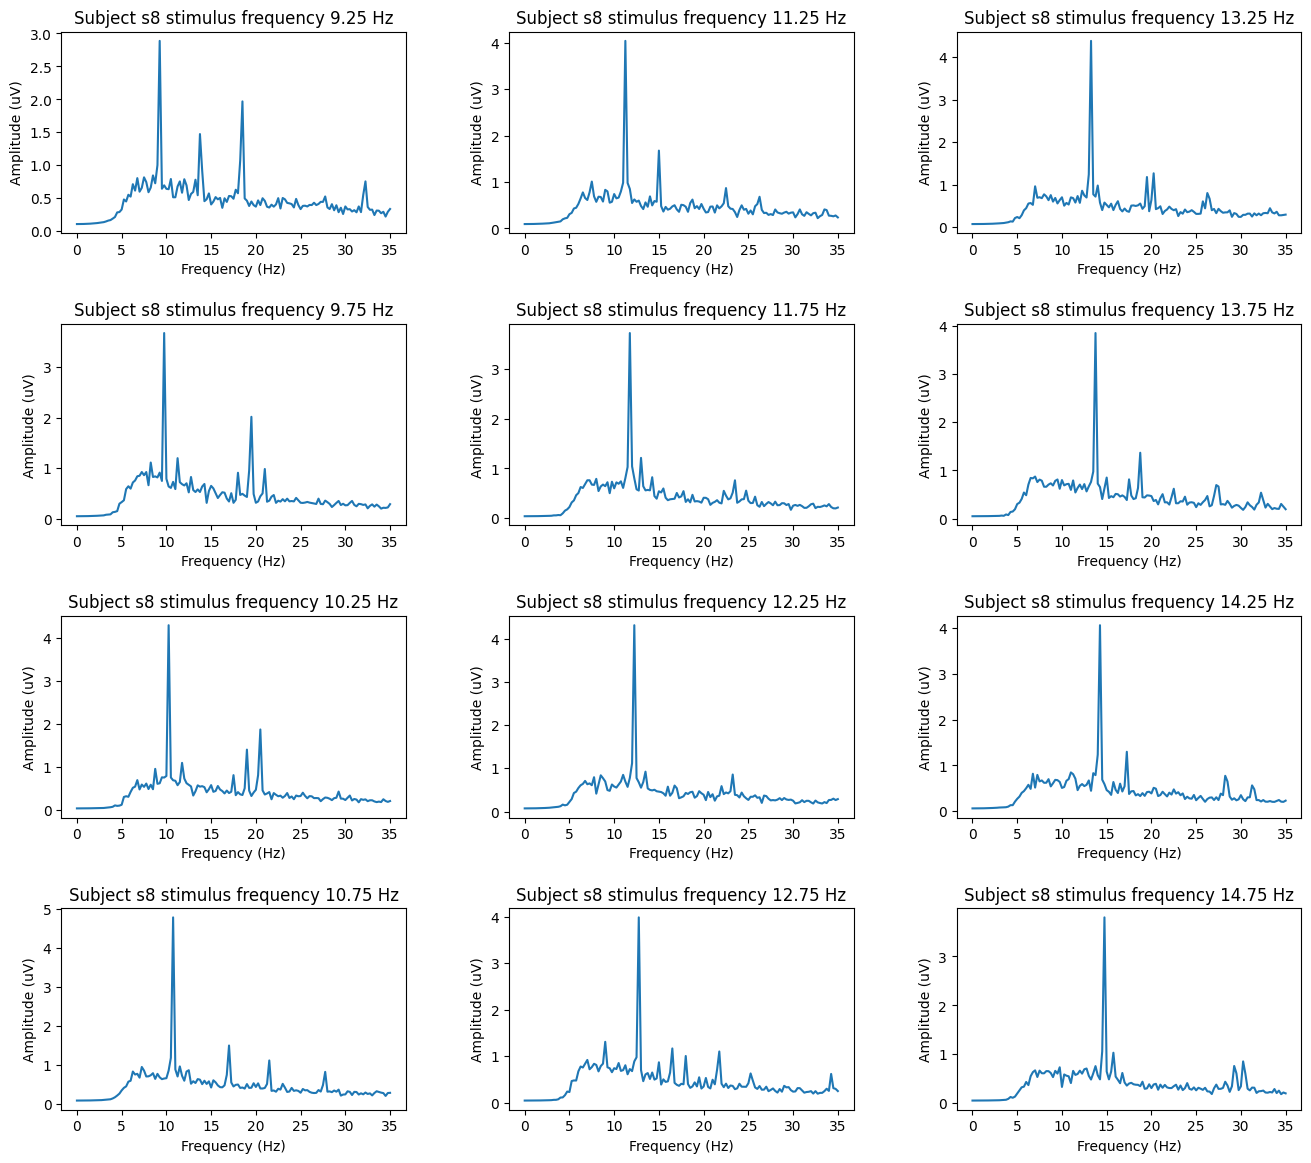

In [23]:
subject = 's8' 
channel = 7  

fig, axes = plt.subplots(4, 3, figsize=(16, 14), gridspec_kw=dict(hspace=0.45, wspace=0.3))
axes = axes.reshape(-1) 

plot_spectrum(axes, magnitude_spectrum[subject], FFT_PARAMS['resolution'], num_classes, 
               subject, channel, flicker_freq)


### Subject 9

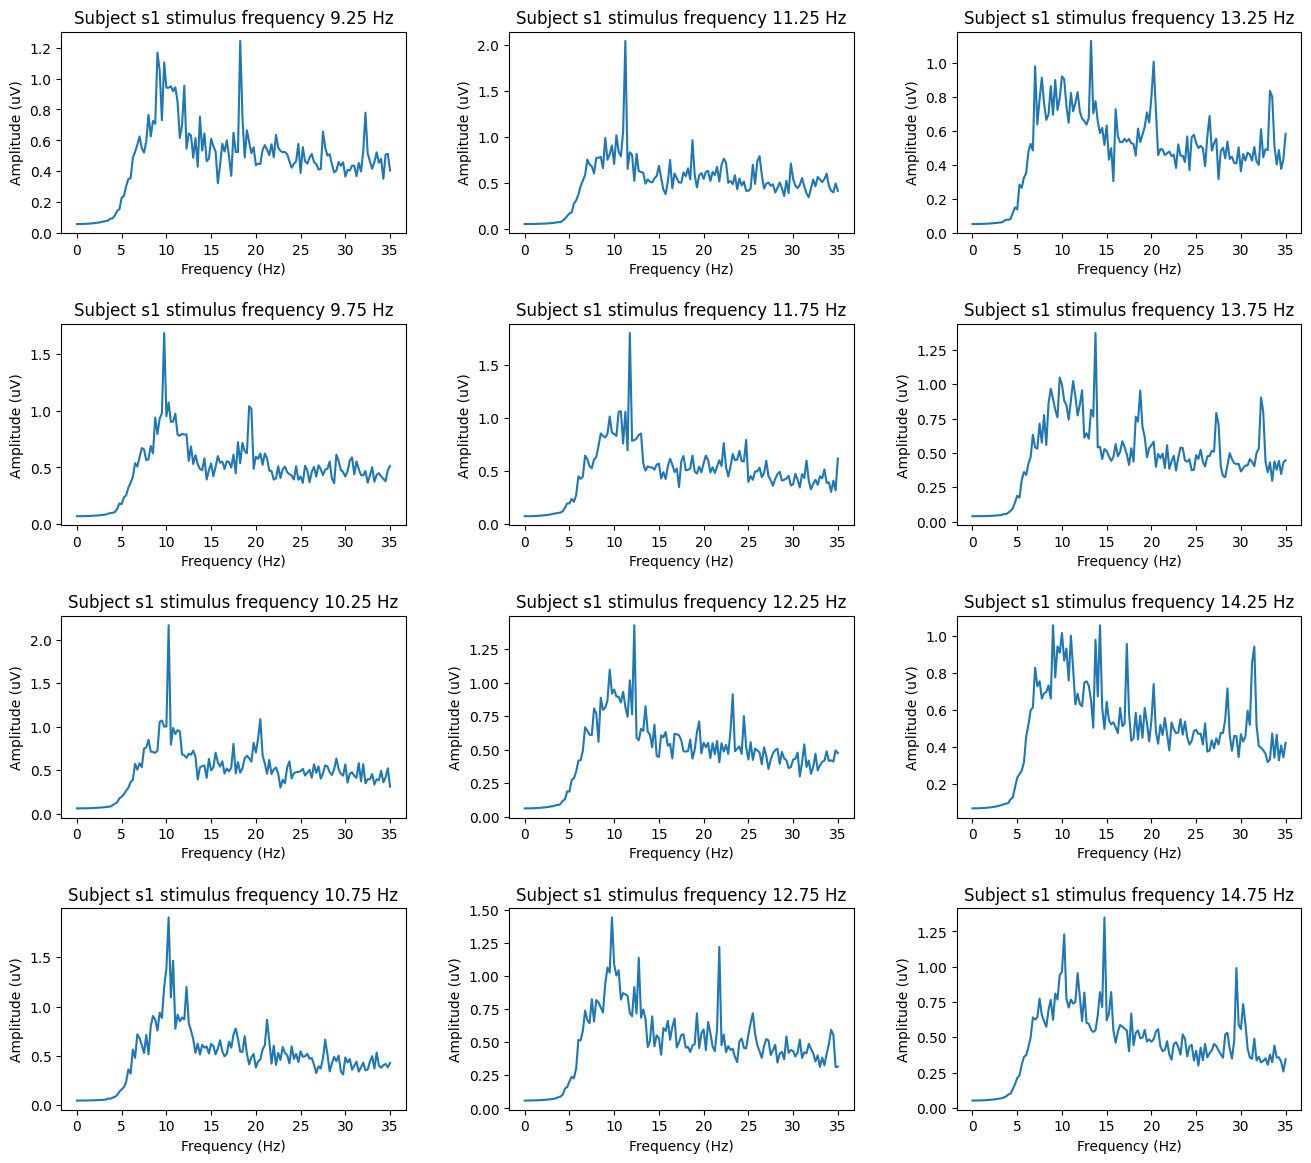

In [24]:
subject = 's1' 
channel = 7  

fig, axes = plt.subplots(4, 3, figsize=(16, 14), gridspec_kw=dict(hspace=0.45, wspace=0.3))
axes = axes.reshape(-1) 

plot_spectrum(axes, magnitude_spectrum[subject], FFT_PARAMS['resolution'], num_classes, 
               subject, channel, flicker_freq)


### Subject 10

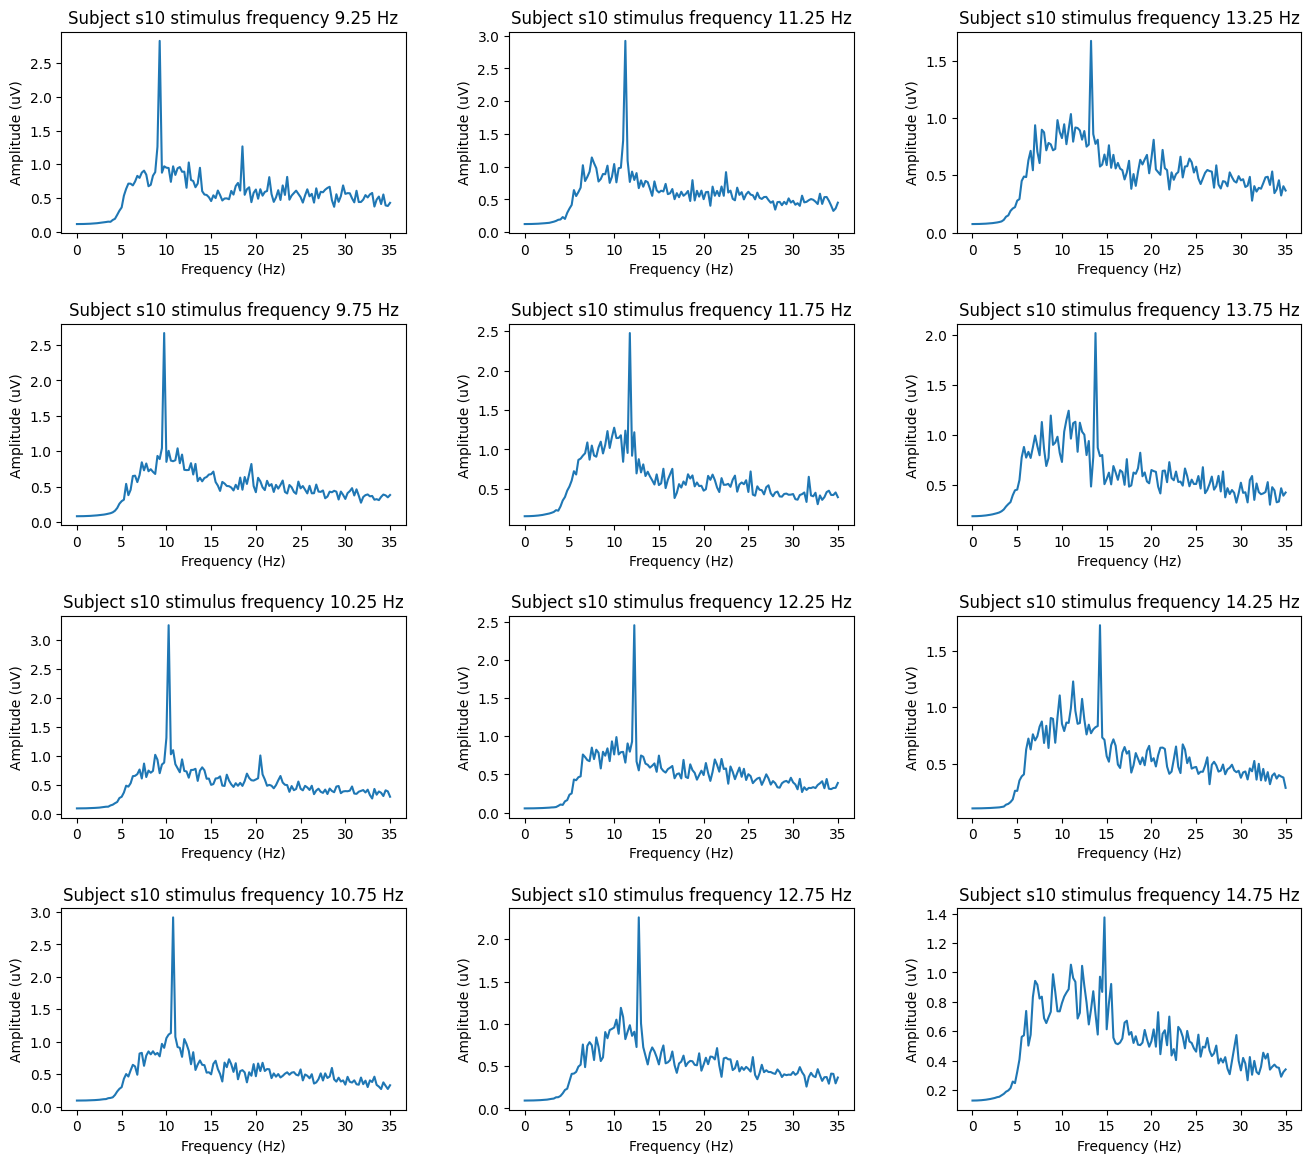

In [26]:
subject = 's10' 
channel = 7  

fig, axes = plt.subplots(4, 3, figsize=(16, 14), gridspec_kw=dict(hspace=0.45, wspace=0.3))
axes = axes.reshape(-1) 

plot_spectrum(axes, magnitude_spectrum[subject], FFT_PARAMS['resolution'], num_classes, 
               subject, channel, flicker_freq)
